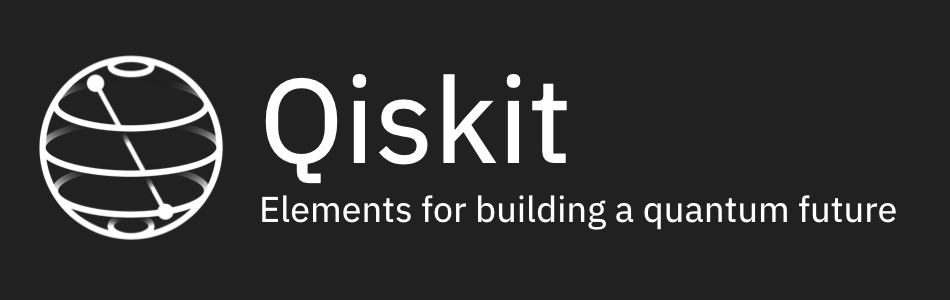

## Repetition Codes
---

* **Last Updated:** June 11, 2019
* **Requires:** qiskit-terra 0.8, qiskit-ignis 0.1.2, qiskit-aer 0.2

## Introduction

In quantum error correction we take many noisy qubits (which we call *physical qubits*) and use them to store a smaller number of *logical qubits*. The error correction procedure is designed to detect and correct for the effects of noise. This makes the logical qubits much less noisy and more reliable than the physical ones from which they are built.

The repetition code is a simple example of quantum error correction, in which a logical *bit* is stored rather than a logical *qubit*. A given instance of the repetition code is defined by two numbers, which we call $d$ and $T$.

The $d$ parameter determines how many physical qubits are used. The actual information about the logical bit is stored in $d$ qubits (which we'll call _code qubits_). The encoding is done in a very simple way: to encode a `0`, all these qubits are set in the state $|0\rangle$, to encode a `1` they are set to $|1\rangle$. To readout the value, you can just look at any qubit. To read it out in a way that protects against single qubit errors, you can read out all the qubits and take a majority vote.

It is not only at readout that we can extract useful information that will help us correct errors. We can also extract information while the logical bit sits idle, or even while it is involved in computation.

Since this is an exercise in quantum error correction, we will do this in a way that would also work for logical *qubits*. Specifically, our method of extracting information about errors must not extract any information regarding the stored logical information. In the quantum case, this is required so that we do not disturb superposition states of the stored qubits.

We will extract information over $T$ rounds of _syndrome measurements_. For the repetition code, these are based on the fact that all code qubits should be in the same state (all $|0\rangle$ or all $|1\rangle$). Any departure from this is therefore a signature of error. Specifically, we imagine our $d$ code qubits sitting along a line. We will then perform a measurement on each pair of neighboring code qubits. This will tell us whether they are the same or different, without extracting any information on what their values are.

The implementation of these measurements requires $d-1$ additional qubits, which we will call _link qubits_ for the repetition code. By pefforming two CNOTs between the pair of code qubits and a corresponding link qubit, the required information (and only the required information) is placed on the link qubit and can then be measured.

In [1]:
from qiskit import *
cq = QuantumRegister(2,'code_qubit')
lq = QuantumRegister(1,'link_qubit')
qc = QuantumCircuit(cq,lq)
qc.cx(cq[0],lq[0])
qc.cx(cq[1],lq[0])
print(qc)

                           
code_qubit_0: |0>──■───────
                   │       
code_qubit_1: |0>──┼────■──
                 ┌─┴─┐┌─┴─┐
link_qubit_0: |0>┤ X ├┤ X ├
                 └───┘└───┘


Here we provide tools for creating and testing repetition codes. The first thing we need to do is import them.

In [2]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import GraphDecoder
from qiskit.ignis.verification.topological_codes import lookuptable_decoding, postselection_decoding

## Creating a repetition code

The `repetition_code` class creates a code for given values of $d$ and $T$.

In [3]:
d = 3
T = 2
code = RepetitionCode(d,T)

With this we can inspect various properties of the code, such as the names of the qubit registers used for the code and ancilla qubits.

In [4]:
code.qubit_registers

{'code_qubit', 'link_qubit'}

These registers are also attributes of the `repetition_code` object.

In [5]:
code.code_qubit

QuantumRegister(3, 'code_qubit')

You can also access the quantum circuits that implement the code. Two of these are produced: one for each of the two possible logical bit values.

In [6]:
for log in ['0','1']:
    print('\n========= logical',log,'=========\n')
    print( code.circuit[log] )


========= logical 0 =========

                      ┌───┐     ┌───┐     ┌─┐           ░ ┌───┐     ┌───┐     »
     link_qubit_0: |0>┤ X ├─────┤ X ├─────┤M├─|0>───────░─┤ X ├─────┤ X ├─────»
                      └─┬─┘┌───┐└─┬─┘┌───┐└╥┘ ┌─┐       ░ └─┬─┘┌───┐└─┬─┘┌───┐»
     link_qubit_1: |0>──┼──┤ X ├──┼──┤ X ├─╫──┤M├──|0>──░───┼──┤ X ├──┼──┤ X ├»
                        │  └─┬─┘  │  └─┬─┘ ║  └╥┘       ░   │  └─┬─┘  │  └─┬─┘»
     code_qubit_0: |0>──■────┼────┼────┼───╫───╫────────░───■────┼────┼────┼──»
                             │    │    │   ║   ║        ░        │    │    │  »
     code_qubit_1: |0>───────■────■────┼───╫───╫────────░────────■────■────┼──»
                                       │   ║   ║        ░                  │  »
     code_qubit_2: |0>─────────────────■───╫───╫────────░──────────────────■──»
                                           ║   ║        ░                     »
round_0_link_bit_0: 0 ═════════════════════╩═══╬══════════════════════════════»
        

## Building a custom repetition code

You can also implement measurement rounds and logical `X` gates yourself. For example, let's set up a code with no syndrome measurement rounds.

In [7]:
empty_code = RepetitionCode(3,0)

This does nothing but set up two circuits for the two logical encoded states. There are no syndrome measurement rounds, and no final readout.

In [8]:
def print_circuits(code):
    for log in ['0','1']:
        print('\n========= logical',log,'=========\n')
        print( code.circuit[log] )
            
print_circuits(empty_code)


========= logical 0 =========

                 
link_qubit_0: |0>
                 
link_qubit_1: |0>
                 
code_qubit_0: |0>
                 
code_qubit_1: |0>
                 
code_qubit_2: |0>
                 

========= logical 1 =========

                       ░ 
link_qubit_0: |0>──────░─
                       ░ 
link_qubit_1: |0>──────░─
                 ┌───┐ ░ 
code_qubit_0: |0>┤ X ├─░─
                 ├───┤ ░ 
code_qubit_1: |0>┤ X ├─░─
                 ├───┤ ░ 
code_qubit_2: |0>┤ X ├─░─
                 └───┘ ░ 


We can add a round using the `syndrome_measurement()` method.

In [9]:
empty_code.syndrome_measurement()
print_circuits(empty_code)


========= logical 0 =========

                      ┌───┐     ┌───┐     ┌─┐           ░ 
     link_qubit_0: |0>┤ X ├─────┤ X ├─────┤M├─|0>───────░─
                      └─┬─┘┌───┐└─┬─┘┌───┐└╥┘ ┌─┐       ░ 
     link_qubit_1: |0>──┼──┤ X ├──┼──┤ X ├─╫──┤M├──|0>──░─
                        │  └─┬─┘  │  └─┬─┘ ║  └╥┘       ░ 
     code_qubit_0: |0>──■────┼────┼────┼───╫───╫────────░─
                             │    │    │   ║   ║        ░ 
     code_qubit_1: |0>───────■────■────┼───╫───╫────────░─
                                       │   ║   ║        ░ 
     code_qubit_2: |0>─────────────────■───╫───╫────────░─
                                           ║   ║        ░ 
round_0_link_bit_0: 0 ═════════════════════╩═══╬══════════
                                               ║          
round_0_link_bit_1: 0 ═════════════════════════╩══════════
                                                          

========= logical 1 =========

                            ░ ┌───┐     ┌───┐     ┌

A logical `X` operation can be added using the `x()` method. 

In [10]:
empty_code.x()
print_circuits(empty_code)


========= logical 0 =========

                      ┌───┐     ┌───┐     ┌─┐           ░       ░ 
     link_qubit_0: |0>┤ X ├─────┤ X ├─────┤M├─|0>───────░───────░─
                      └─┬─┘┌───┐└─┬─┘┌───┐└╥┘ ┌─┐       ░       ░ 
     link_qubit_1: |0>──┼──┤ X ├──┼──┤ X ├─╫──┤M├──|0>──░───────░─
                        │  └─┬─┘  │  └─┬─┘ ║  └╥┘       ░ ┌───┐ ░ 
     code_qubit_0: |0>──■────┼────┼────┼───╫───╫────────░─┤ X ├─░─
                             │    │    │   ║   ║        ░ ├───┤ ░ 
     code_qubit_1: |0>───────■────■────┼───╫───╫────────░─┤ X ├─░─
                                       │   ║   ║        ░ ├───┤ ░ 
     code_qubit_2: |0>─────────────────■───╫───╫────────░─┤ X ├─░─
                                           ║   ║        ░ └───┘ ░ 
round_0_link_bit_0: 0 ═════════════════════╩═══╬══════════════════
                                               ║                  
round_0_link_bit_1: 0 ═════════════════════════╩══════════════════
                              

This also has a `logs` kwarg, which is a list of the circuits for which `X` is applied. This is `['0','1']` by default.

Final readout is then done with the `readout()` method.

In [11]:
empty_code.readout()
print_circuits(empty_code)


========= logical 0 =========

                      ┌───┐     ┌───┐     ┌─┐           ░       ░          
     link_qubit_0: |0>┤ X ├─────┤ X ├─────┤M├─|0>───────░───────░──────────
                      └─┬─┘┌───┐└─┬─┘┌───┐└╥┘ ┌─┐       ░       ░          
     link_qubit_1: |0>──┼──┤ X ├──┼──┤ X ├─╫──┤M├──|0>──░───────░──────────
                        │  └─┬─┘  │  └─┬─┘ ║  └╥┘       ░ ┌───┐ ░ ┌─┐      
     code_qubit_0: |0>──■────┼────┼────┼───╫───╫────────░─┤ X ├─░─┤M├──────
                             │    │    │   ║   ║        ░ ├───┤ ░ └╥┘┌─┐   
     code_qubit_1: |0>───────■────■────┼───╫───╫────────░─┤ X ├─░──╫─┤M├───
                                       │   ║   ║        ░ ├───┤ ░  ║ └╥┘┌─┐
     code_qubit_2: |0>─────────────────■───╫───╫────────░─┤ X ├─░──╫──╫─┤M├
                                           ║   ║        ░ └───┘ ░  ║  ║ └╥┘
round_0_link_bit_0: 0 ═════════════════════╩═══╬═══════════════════╬══╬══╬═
                                               ║        

## Running a repetition code

The code object produces the circuits required for the code. The user can then run them using any method they prefer, allowing full control over compilation, backends, noise models and so on. 

For example, here we run them without noise on the `qasm_simulator`.

In [12]:
circuits = code.get_circuit_list()
job = execute( circuits, Aer.get_backend('qasm_simulator') )
raw_results = {}
for log in ['0','1']:
    raw_results[log] = job.result().get_counts(log)
    print('\n========= logical',log,'=========\n')
    print(raw_results[log])


========= logical 0 =========

{'000 00 00': 1024}

========= logical 1 =========

{'111 00 00': 1024}


Here the strings from right to left represent the outputs of the syndrome measurement rounds, followed by the final measurement of the code qubits.

These results need to be rewritten in a different form in order to be decoded. To do this we can use the `process_results` method of the code object.

In [13]:
code.process_results( raw_results )

{'0': {'0 0  00 00 00': 1024}, '1': {'1 1  00 00 00': 1024}}

The result is a dictionary whose keys are bit strings that represent outputs of the circuit, and the values represent the number of shots for which this output occurred.

The strings are not the direct output from the circuits. They have been processed to take the form that helps us correct errors. Here's a short guided tour.

* The `0 0` to the far left for the logical `0` result, and the `1 1` to the far left of the logical `1`, are the logical readout. Any code qubit could be used for this readout, since they should (without errors) all be equal. So we could have just one result here, for one arbitrarily chosen code qubit. Or we could have $d$, one for each qubit. Instead we have two, from the two qubits at either end of the line. This is because it works best with the decoder (which we'll use later). In the absence of errors, these two values will always be equal.

* The following `0000` is the $d-1$ results of the syndrome measurements for the first round.A `0` implies that the corresponding pair of qubits where the same, and `1` implies different. There are $d-1$ results because the line of $d$ code qubits has $d-1$ possible neighboring pairs. In the absence of errors, they will all be `0`.

* The `0000` that follows that is the syndrome change between the first and second rounds. It is therefore the bitwise `OR` of the syndrome measurement results from the second round with those from the first. In the absence of errors, they will all be `0`.

* Subsequent blocks follow the same formula, though the last requires some comment. This is not measured using the standard method (with a link qubit). Instead it is calculated from the final readout measurement of all code qubits. Again it is presented as a syndrome change, and will be all `0` in the absence of errors. This is the $T+1$-th block of syndrome measurements since, as it is not done in the same way as the others, it is not counted among the $T$ syndrome measurement rounds.

**Example 1:** `0 0  0110 0000 0000` would represent a $d=5$, $T=2$ repetition code with encoded `0`. The syndrome shows that (most likely) the middle code qubit was flipped by an error before the first measurement round. This causes it to disagree with both neighboring code qubits for the rest of the circuit. This is shown by the syndrome in the first round, but the blocks for subsequent rounds do not report it as it no longer represents a change. Other sets of errors could also have caused this syndrome, but they would need to be more complex and so presumably less likely.

**Example 2:** `0 0  0010 0010 0000` would represent a $d=5$, $T=2$ repetition code with encoded `0`. Here one of the syndrome measurements reported a difference between two code qubits in the first round, leading to a `1`. The next round did not see the same effect, and so resulted in a `0`. However, since this disagreed with the previous result for the same syndrome measurement, and since we track syndrome changes, this change results in another `1`. Subsequent rounds also do not detect anything, but this no longer represents a change and hence results in a `0` in the same position. Most likely the measurement result leading to the first `1` was an error.

**Example 3:** `0 1  0000 0001 0000` would represent a $d=5$, $T=2$ repetition code with encoded `1`. A code qubit on the end of the line is flipped before the second round of syndrome measurements. This is detected by only a single syndrome measurement, because it is on the end of the line. For the same reason, it also disturbs one of the logical readouts.

Note that in all these examples, a single error causes exactly two characters in the string to change from the value it would have with no errors. This is, in fact, the reason why the logical output consists of both endpoints. It is a property that will be used by the decoder.

To see the effects of noise, we need to specify a noise model. For example, let's set up a simple noise model with gate and measurement errors.

In [14]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
        
    return noise_model

In [15]:
noise_model = get_noise(0.04,0.04)

This can then be run to generate noisy results. Let's make a quick function to do this, and then run it.

In [16]:
def get_syndrome(code,noise_model,shots=1014):
    
    circuits = code.get_circuit_list()

    job = execute( circuits, Aer.get_backend('qasm_simulator'),noise_model=noise_model, shots=shots )
    raw_results = {}
    for log in ['0','1']:
        raw_results[log] = job.result().get_counts(log)

    return code.process_results( raw_results )

In [17]:
get_syndrome(code,noise_model)

{'0': {'1 1  10 10 11': 1,
  '0 0  00 01 01': 36,
  '0 0  10 11 10': 1,
  '0 1  00 10 11': 2,
  '0 1  01 10 10': 1,
  '0 1  00 00 10': 3,
  '0 0  00 00 11': 32,
  '0 0  00 11 11': 6,
  '0 1  01 00 00': 1,
  '0 0  01 00 10': 2,
  '0 1  00 11 10': 1,
  '0 0  11 11 00': 2,
  '0 0  00 01 10': 20,
  '1 0  01 01 10': 7,
  '0 0  01 00 01': 2,
  '0 1  10 10 01': 2,
  '1 0  00 00 01': 4,
  '1 1  00 01 10': 1,
  '0 0  10 10 00': 60,
  '0 1  00 00 01': 37,
  '1 0  00 11 10': 2,
  '0 0  00 00 00': 554,
  '0 0  10 10 11': 3,
  '1 0  01 10 10': 2,
  '0 1  00 01 00': 11,
  '1 0  10 01 01': 1,
  '0 0  11 00 00': 3,
  '1 0  10 10 10': 4,
  '1 0  00 00 10': 47,
  '0 1  00 11 01': 1,
  '1 1  01 10 00': 1,
  '0 0  01 01 00': 48,
  '1 0  00 10 00': 19,
  '0 1  10 11 00': 2,
  '0 0  00 11 00': 12,
  '0 1  01 11 11': 1,
  '0 1  00 01 11': 1,
  '1 0  00 01 11': 2,
  '0 0  00 10 10': 41,
  '1 1  00 00 11': 4,
  '0 0  10 11 01': 4,
  '0 0  01 11 10': 2,
  '1 0  01 01 01': 2,
  '0 0  00 10 01': 5,
  '0 0  01 10 

Here the non-noisy results are the most likely. The rest of the samples are distributed among other possibilities with non-trivial syndromes.

## Decoding a repetition code

Noisy results can change the logical value at readout, and so affect our ability to read out the logical qubit. This can be mitigated by looking at the syndrome values. These can tell us whether or not the logical values are most likely to have changed, and so allow us to correct for the errors. The process of analyzing the syndrome to correct for the errors is called 'decoding'. We do this by building a decoding object for our code.

In [18]:
dec = GraphDecoder( RepetitionCode(4,2) )

This analyzes the code by seeing how different kinds of error change the output. With this information, along with a decoding algorithm, we can determine what the logical value is most likely to have been.

For example, let's use the 'matching' algorithm to decode, which is based on minimum weight perfect matching. This takes specific output strings as input. We'll give it the simple example string `'1 0  001 100 100'`, for a logical `1` that has suffered two errors.

In [19]:
dec.matching('1 0  001 100 100')

'1 1'

The output is what the logical part should have been. As you can see, the decoder correctly determined that the readout should have been of a logical `1`.

When we take many samples, we can determine the probability with which the decoder is incorrect. This should decrease exponentially as the code size is increased, since the configurations of noise that fool the decoder become less likely. The probability of a logical error is calculated using the `logical_prob()` method. This runs matching by default, but other algorithms can be specified by the `algorithm` kwarg.

In [20]:
for d in range(3,8):
    
    code = RepetitionCode(d,2)
    
    results = get_syndrome(code,noise_model=noise_model,shots=8192)
    
    dec = GraphDecoder(code)

    logical_prob_match = dec.get_logical_prob(results)
    logical_prob_lookup = lookuptable_decoding(results,results)
    logical_prob_post = postselection_decoding(results)

    for log in ['0','1']:
        print('d =',d,',log =',log)
        print('logical error probability for matching      =',logical_prob_match[log])
        print('logical error probability for lookup table  =',logical_prob_lookup[log])
        print('logical error probability for postselection =',logical_prob_post[log])
        print('')
    print('')

d = 3 ,log = 0
logical error probability for matching      = 0.0323486328125
logical error probability for lookup table  = 0.021484375
logical error probability for postselection = 0.0004528985507246377

d = 3 ,log = 1
logical error probability for matching      = 0.02880859375
logical error probability for lookup table  = 0.0169677734375
logical error probability for postselection = 0.0


d = 4 ,log = 0
logical error probability for matching      = 0.01806640625
logical error probability for lookup table  = 0.01171875
logical error probability for postselection = 0.0

d = 4 ,log = 1
logical error probability for matching      = 0.0206298828125
logical error probability for lookup table  = 0.0074462890625
logical error probability for postselection = 0.0


d = 5 ,log = 0
logical error probability for matching      = 0.0091552734375
logical error probability for lookup table  = 0.002197265625
logical error probability for postselection = 0.0

d = 5 ,log = 1
logical error probability for

In [21]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright